## Imports

In [2]:
import gym
from IPython.display import clear_output

import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from random import random
import time

## Load MountainCar-V0

In [3]:
env = gym.make('MountainCar-v0')

In [4]:
print('State:', env.observation_space)
print('Action:', env.action_space)
print('State High', env.observation_space.high)
print('State Low', env.observation_space.low)

State: Box(2,)
Action: Discrete(3)
State High [0.6  0.07]
State Low [-1.2  -0.07]


### Map State Space (Continuous to Discrete to 1D)

In [5]:
discrete_factor = 20
def map_state_index(cstate):
    diff = env.observation_space.high - env.observation_space.low
    norm = cstate - env.observation_space.low
    dstate = (norm / diff * discrete_factor).astype(int)
    index = discrete_factor * dstate[0] + dstate[1]
    return index

## Q-Learning

### Hyperparameters

In [6]:
alpha = 0.1 # Incremental Mean
gamma = 1 # Discount
epsilon = 0.01 # E-Greedy
max_episodes = int(1e4)

### Action Values

In [7]:
q_table = np.zeros([
    discrete_factor ** 2, 
    env.action_space.n])
acc_rewards = np.zeros([max_episodes])

### Run

In [24]:
%%time
for i in range(max_episodes):
    state = env.reset()
    acc_reward = 0
    while True:
        # E-Greedy
        state_index = map_state_index(state)
        if random() < epsilon: action = env.action_space.sample()
        else: action = np.argmax(q_table[state_index])
        next_state, reward, done, info = env.step(action)
        next_state_index = map_state_index(next_state)
        
        really_done = info.get('TimeLimit.truncated')
        if really_done is False:
            break
        
        # Update Action Values
        old_value = q_table[state_index, action]
        returns = reward + gamma * np.max(q_table[next_state_index])
        td_error = returns - old_value
        q_table[state_index, action] += alpha * td_error
        
        # Continue
        state = next_state
        acc_reward += reward
#         clear_output(wait=True)
#         env.render()
#         print(state_index)
#         print(i, acc_reward)
    acc_rewards[i] = acc_reward

Wall time: 3min 27s


### Plot Episodes Rewards

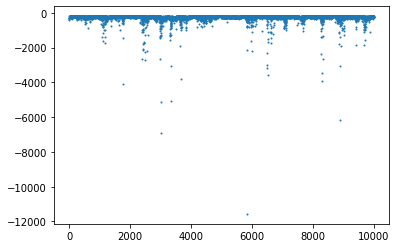

Mean -264.2856


In [28]:
%matplotlib inline

plt.scatter(range(len(acc_rewards)), acc_rewards, s=1)
plt.show()
print('Mean', np.mean(acc_rewards))

### Plot State Values

In [32]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(
    np.linspace(
        env.observation_space.low[0], 
        env.observation_space.high[0],
        discrete_factor),
    np.linspace(
        env.observation_space.low[1], 
        env.observation_space.high[1],
        discrete_factor))

Z = np.max(q_table, axis=1)
# Z *= -1
Z = Z.reshape((discrete_factor, discrete_factor))

ax.plot_wireframe(X, Y, Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('State-Value')
plt.show()

### Result

In [21]:
state = env.reset()
acc_reward = 0
done = False
#for i in range(300):
while not done:
    action = np.argmax(q_table[map_state_index(state)])
    state, reward, done, info = env.step(action)
    
    really_done = info.get('TimeLimit.truncated')
    if really_done is False:
        break
    
    acc_reward += reward
    clear_output(wait=True)
    env.render()
    print('Acc Reward:', acc_reward)
    print(info)
    time.sleep(0.01)

Acc Reward: -148.0
{}
